In [153]:
import snowflake.connector
import snowflake.snowpark as snowpark
from snowflake.snowpark import Session
from snowflake.snowpark.functions import *
import pandas as pd
import numpy as np
import random 
import matplotlib.pyplot as plt

In [154]:
# propensity score change?
conn = {
    "account": "square",
    "user": "yunan@squareup.com", # enter email
    "authenticator":"externalbrowser",
    "database":"app_engage", 
    "schema":"app_engage_etl" } 
session = Session.builder.configs(conn).create()


Initiating login request with your identity provider. A browser window should have opened for you to complete the login. If you can't see it, check existing browser windows, or your OS settings. Press CTRL+C to abort and try again...
Going to open: https://login.block.xyz/app/snowflake/exkv7jkolejY0S2CJ696/sso/saml?SAMLRequest=jZLdctowEIVfxaNeY8k2IUEDZFwIKZk0oWCYSe8UWyYKsuRqZWz69JX5ySQXyfROI52jb3fPDq6bQno7bkBoNUSBT5DHVaozoTZDtEqmnSvkgWUqY1IrPkR7Duh6NABWyJLGlX1RC%2F6n4mA995EC2j4MUWUU1QwEUMUKDtSmdBn%2FvKehTygD4MY6HDpZMhCO9WJtSTGu69qvI1%2BbDQ4JIZj0sVO1km%2FoHaL8mlEabXWq5dnSuJ4%2BQQSYdFuEUzjC%2FGT8LtRxBF9Rno8ioD%2BSZN6ZPy4T5MXn7sZaQVVws%2BRmJ1K%2BWtwfCwBXwfLXKl7c%2BKB0nUu25akuysq6r3x3wjnPsNQb4QY0mwxRuRVZznKxfozvxG112zPJ5ZxvrLwhF00T5Q%2B7SbSaRou46j6tL0iKvPU5zrCNcwZQ8ZlqQ7TuioRRh%2FQ7QTcJIxr0aHDlh73ub%2BRNXIhCMXtwnis91OE%2FS51u%2FWb%2FF7OyxG9lY95sd5evWy356xNZhuO7Xr%2BHATRuI0LHLaEHvhn9V%2B8D%2FN5y2rIHN%2FjZZK6lSPfeVJuC2c9zCfzgcCOyTn6QUl4wIeMsMxzA5SOlrseGM%2BuW2ZqKIzw6Uj%2Bu8%2Bgf&RelayState=6

In [ ]:
# the sql used to generate temp table
"""
create or replace table app_engage.app_engage_temp.econv as (
WITH base AS(
SELECT 
    he.best_available_merchant_token as merchant_token, 
    date(prediction_at) as prediction_date, 
    conversion_square_card,
    ROW_NUMBER() OVER(PARTITION BY prediction_date ORDER BY conversion_square_card DESC) as econv_rank,
    dense_rank()over(order by merchant_token asc) as flag,
    converted_at,
    first_successful_activation_request_approved_at,
    pe.product_name,
    pe.event_type
FROM SELLER_DS.MESSAGEML.HISTORICAL_EMAIL he
JOIN app_bi.hexagon.vdim_merchant vm
  on he.best_available_merchant_token = vm.merchant_token
left join app_engage.app_engage_etl.grm_product_events pe
  on he.best_available_merchant_token = pe.best_available_merchant_token
where product_name = 'Instant Transfer'
  and event_type = 'top_of_funnel'
)


select 
    merchant_token,
    prediction_date,
    conversion_square_card,
    econv_rank,
    flag,
    converted_at,
    iff(econv_rank<1050000,1,0) as in_threshold,
    min(prediction_date)over(partition by MERCHANT_TOKEN,in_threshold) as first_in_threshold,
    min(prediction_date)over(partition by MERCHANT_TOKEN) as first_prediction
from base 
qualify PREDICTION_date between first_prediction and dateadd(day,365,first_prediction)
  and year(first_prediction)=2022
)
"""

In [156]:
dtc = session.sql("""
select * from app_engage.app_engage_temp.econv
 """)

In [157]:
df1 = dtc.to_pandas()

In [158]:
random_list = random.sample(list(df1.FLAG.unique()),3000)
# sample 3000 sellers from all merchants

In [159]:
df = df1[df1.FLAG.isin(random_list)]
df = df.loc[:,['MERCHANT_TOKEN','FLAG','PREDICTION_DATE','ECONV_RANK','CONVERTED_AT','IN_THRESHOLD','FIRST_IN_THRESHOLD']]
df = df.sort_values(by=['FLAG','PREDICTION_DATE'], ascending=[True,True])
df['Relative_Day'] = df.groupby('FLAG').cumcount()
df.head()

,MERCHANT_TOKEN,FLAG,PREDICTION_DATE,ECONV_RANK,CONVERTED_AT,IN_THRESHOLD,FIRST_IN_THRESHOLD,Relative_Day
377597438,03FNR6RTTY237,27486,2022-09-16,1792390,2016-05-03 08:32:12,0,2022-09-16,0
377597464,03FNR6RTTY237,27486,2022-09-20,2214677,2016-05-03 08:32:12,0,2022-09-16,1
377597479,03FNR6RTTY237,27486,2022-09-21,2305783,2016-05-03 08:32:12,0,2022-09-16,2
377597550,03FNR6RTTY237,27486,2022-09-22,2335475,2016-05-03 08:32:12,0,2022-09-16,3
377597675,03FNR6RTTY237,27486,2022-09-23,2364203,2016-05-03 08:32:12,0,2022-09-16,4


In [166]:
# a list of sellers who experienced ToF instant transfer after 
instant_transfer = df[df.CONVERTED_AT >= df.PREDICTION_DATE].FLAG.unique()
#instant_transfer[:20]

array([  55096,  502048,  700407,  979070, 1202495, 1558430, 1924567,
       2271461, 2288888, 2360535, 2425161, 2822553, 3100310, 3424195,
       3896290, 4194552, 4332835, 4873988, 4889705])

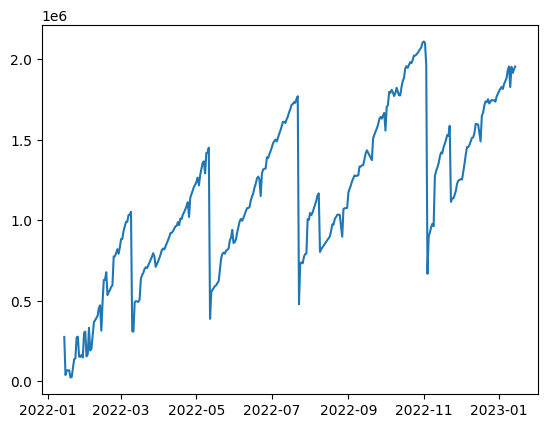

          MERCHANT_TOKEN     FLAG PREDICTION_DATE  ECONV_RANK  \
310085835  9NBV3VD0DWF3E  2425161      2022-01-14      274628   
310085819  9NBV3VD0DWF3E  2425161      2022-01-15       38190   
310085860  9NBV3VD0DWF3E  2425161      2022-01-16       65990   
310085680  9NBV3VD0DWF3E  2425161      2022-01-17       67700   
310085632  9NBV3VD0DWF3E  2425161      2022-01-18       67066   
310085832  9NBV3VD0DWF3E  2425161      2022-01-19       22803   
310085665  9NBV3VD0DWF3E  2425161      2022-01-20       25209   
310085730  9NBV3VD0DWF3E  2425161      2022-01-21       80492   
310085742  9NBV3VD0DWF3E  2425161      2022-01-22      135682   
310085825  9NBV3VD0DWF3E  2425161      2022-01-23      140796   
310085956  9NBV3VD0DWF3E  2425161      2022-01-24      271506   
310085899  9NBV3VD0DWF3E  2425161      2022-01-25      276601   
310085775  9NBV3VD0DWF3E  2425161      2022-01-26      152319   
310085648  9NBV3VD0DWF3E  2425161      2022-01-27      151210   
310085622  9NBV3VD0DWF3E 

In [170]:
# Draw a sample seller and see its pattern
test = df[df.FLAG==2425161]
test = test.sort_values(by="PREDICTION_DATE", ascending=True)
test['Relative_Day'] = test.groupby('FLAG').cumcount()
plt.plot(test.PREDICTION_DATE,test.ECONV_RANK)
plt.show()
pd.set_option('display.max_rows', None)


In [171]:
change_in3s = []
change_in10s = []
change_in15s = []
df_ins = df[df.FLAG.isin(instant_transfer)]
for flag in instant_transfer:
    try:
        current_rank = df_ins[(df_ins.PREDICTION_DATE==df_ins.CONVERTED_AT.dt.date) & (df_ins.FLAG==flag)].ECONV_RANK.iloc[0]
    except:
        current_rank = np.NaN
    try:
        relative_day = df_ins[(df_ins.PREDICTION_DATE==df_ins.CONVERTED_AT.dt.date) & (df_ins.FLAG==flag)].Relative_Day.iloc[0]
    except:
        relative_day = np.NaN
    try:
        rank_in3 = df_ins[(df_ins.Relative_Day==relative_day+3) & (df_ins.FLAG==flag)].ECONV_RANK
    except:
        rank_in3 = np.NaN
        
    try:
        rank_in10 = df_ins[(df_ins.Relative_Day==relative_day+10) & (df_ins.FLAG==flag)].ECONV_RANK
    except:
        rank_in10 = np.NaN
        
    try:
        rank_in15 = df_ins[(df.Relative_Day==relative_day+15) & (df_ins.FLAG==flag)].ECONV_RANK
    except:
        rank_in15 = np.NaN
    if len((current_rank - rank_in3).to_list())>0:
        change_in3s.append((current_rank - rank_in3).to_list()[0])
    if len((current_rank - rank_in10).to_list())>0:
        change_in10s.append((current_rank - rank_in10).to_list()[0])
    if len((current_rank - rank_in15).to_list())>0:
        change_in15s.append((current_rank - rank_in15).to_list()[0])

C:\Users\YunanYan\AppData\Local\Temp\ipykernel_9492\869732642.py:25: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  rank_in15 = df_ins[(df.Relative_Day==relative_day+15) & (df_ins.FLAG==flag)].ECONV_RANK


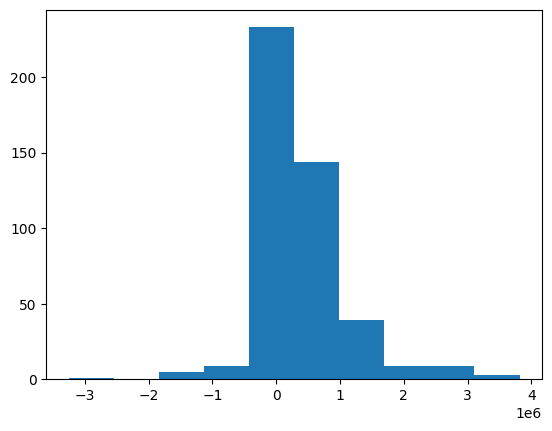

0.7743362831858407

In [173]:
plt.hist(change_in3s)
plt.show()
np.sum([i>0 for i in change_in3s])/len(change_in3s)
# over 77% of sellers have higher rank after 3 days of ToF Instant Transfer

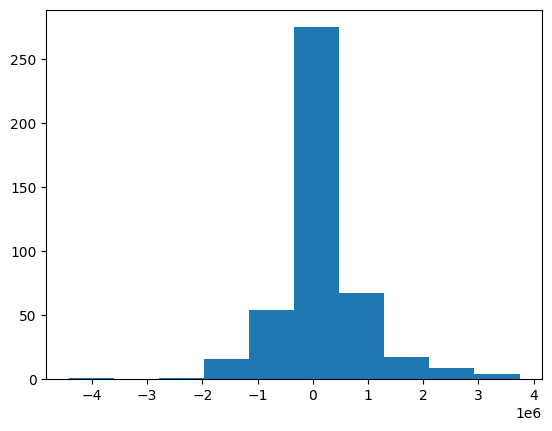

0.5765765765765766

In [174]:
plt.hist(change_in10s)
plt.show()
np.sum([i>0 for i in change_in10s])/len(change_in10s)
# over 58% of sellers have higher rank after 10 days of ToF Instant Transfer

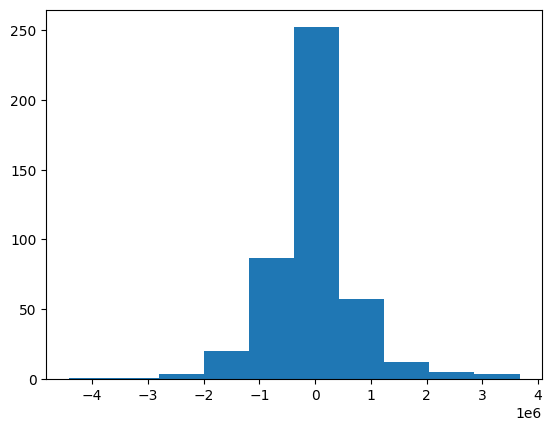

0.4108352144469526

In [175]:
plt.hist(change_in15s)
plt.show()
np.sum([i>0 for i in change_in15s])/len(change_in15s)
# over 41% of sellers have higher rank after 15 days of ToF Instant Transfer

# Conclusion: the effect of this feature would fade off with time
# Recommendation: send email as soon as this feature boosts up ranks

In [176]:
# investigate when people first got into the threshold
df['First_Show_Up'] = df.groupby('FLAG').PREDICTION_DATE.transform("min")
df.FIRST_IN_THRESHOLD = np.where(df.IN_THRESHOLD==0,np.NaN,df.FIRST_IN_THRESHOLD)
df['Relative_Day_In_Thresh'] = (df.FIRST_IN_THRESHOLD-df.First_Show_Up).dt.days
relative_day_in_thresh = df.groupby('FLAG').Relative_Day_In_Thresh.min()

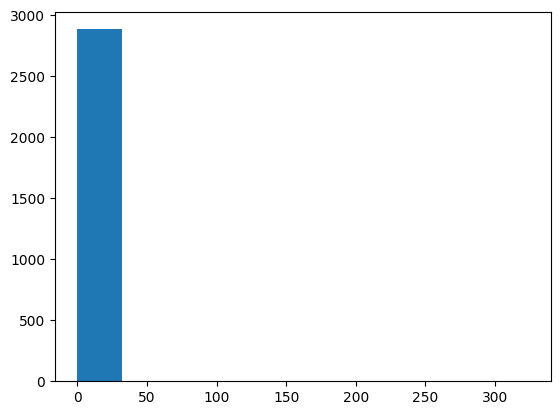

0.0


FLAG
27486    NaN
55096    0.0
61460    0.0
78322    0.0
85396    0.0
Name: Relative_Day_In_Thresh, dtype: float64

In [178]:
plt.hist(relative_day_in_thresh)
plt.show()
print(relative_day_in_thresh.median())
# most sellers appear above the threshold in the first day when they eligible for EconV
relative_day_in_thresh.head()

In [147]:
def normalize(series):
    return (series - series.min()) / (series.max() - series.min())

df['Normalized_Value'] = df.groupby('FLAG')['ECONV_RANK'].transform(normalize)
df['Relative_Change'] = df.groupby('FLAG')['Normalized_Value'].diff().fillna(0)
# here diff use next day to minus current day
# if positive, meaning worse in ranking
median_trend = df.groupby('Relative_Day')['Relative_Change'].median().cumsum()


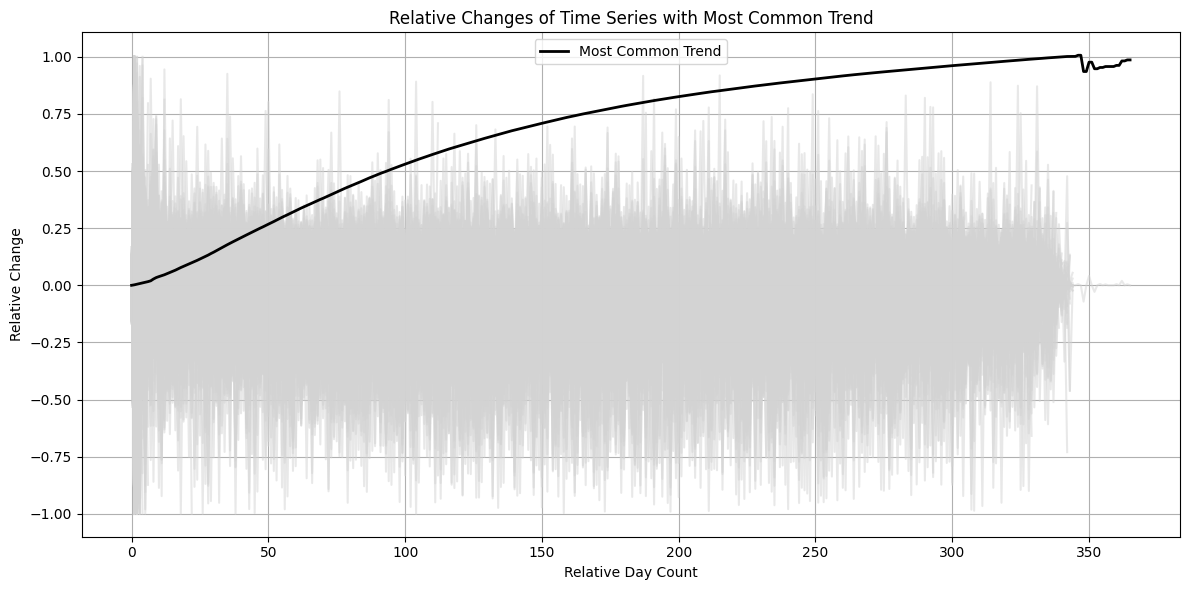

In [148]:
plt.figure(figsize=(12, 6))
df = df[df.Relative_Day<=365]
labels = df['FLAG'].unique()
for label in labels:
    subset = df[df['FLAG'] == label]
    plt.plot(subset['Relative_Day'], subset['Relative_Change'], alpha=0.5, color='lightgray')

# Plot the most common trend based on cumulative median relative changes
plt.plot(median_trend.index, median_trend.values, color='black', linewidth=2, label='Most Common Trend')

plt.title('Relative Changes of Time Series with Most Common Trend')
plt.xlabel('Relative Day Count')
plt.ylabel('Relative Change')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [149]:
def find_jump(arr):
    jump_index = []
    jump_value = []
    magnitude = []
    arr = arr.to_list()
    for i in range(1,len(arr)):
        if arr[i]<=arr[i-1]*0.6:
            jump_index.append(i)
            jump_value.append((arr[i-1],arr[i]))
            magnitude.append(arr[i-1]-arr[i])
    return jump_index, jump_value, magnitude

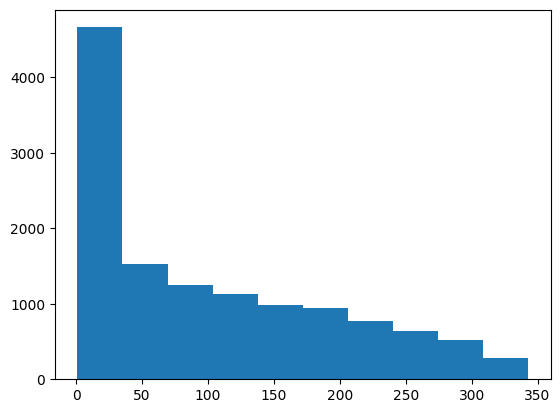

In [151]:
length = []
flag_list = df.FLAG.unique()
for flag in flag_list:
    idx,val,mag = find_jump(df[df.FLAG==flag].ECONV_RANK)
    for item in idx:
        length.append(item)

plt.hist(length)
plt.show()

46